## Imbalanced_Classes

### Steps to take
<font color='grey'>step 1: Import all the necessary python packages</font><br>
<font color='grey'>step 2: Obtain and clean data</font> <br>
<font color='grey'>step 3: Data Exploration</font> <br>
<font color='grey'>step 4: Modify data for Machine Learning</font><br>
<font color='grey'>step 5: Get dummies</font><br>
<font color='grey'>step 6: Split data into train and test</font><br> 
step 6: Standard scaling<br>
step 7: Dealing with Imbalanced Data:
- Logistic Regression "class_weight" parameter
- SMOTE (oversampling)
- Undersampling

step 8: logistic regression<br>
<font color='grey'>step 9: parameter tuning</font><br>
<font color='grey'>step 10: provide actionable recommendations</font><br>



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=14)
import seaborn as sns 
# sns.set(style='white')
# sns.set(style='whitegrid', color_codes=True)

#Machine Learning Modules
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix#, classifiction_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

# autoreload 
%load_ext autoreload
%autoreload 2

#logistic regression script
import logistic_regression

In [2]:
## Load Train data from data/Train
Train = pd.read_csv('data/Train.csv',)

X_train = Train.drop('target', axis = 1)
y_train = Train['target']

X_train.columns

Index(['age', 'campaign', 'pdays', 'previous', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'marital_unknown', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'housing_unknown', 'housing_yes',
       'default_unknown', 'default_yes', 'loan_unknown', 'loan_yes',
       'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

## Step 6: Standard Scaling

In [3]:
# StandardScaler
scaler = StandardScaler().fit(X_train)
columns = X_train.columns

scaled_train = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(scaled_train, columns=columns)
# ## then used 
# # scaler.transform(X_test)
print(X_train_scaled.shape)
X_train_scaled.head()

(32940, 45)


,age,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,-0.293135,-0.564625,-0.19645,1.679762,-0.539824,-0.191649,-0.165773,-0.273916,-0.209108,-0.190026,...,-0.709185,-0.333783,-0.129585,-0.119922,-0.511124,-0.515608,-0.494967,-0.494729,-2.511053,-0.186655
1,-0.676809,-0.204519,-0.19645,-0.350523,-0.539824,-0.191649,-0.165773,-0.273916,-0.209108,-0.190026,...,-0.709185,-0.333783,-0.129585,-0.119922,-0.511124,-0.515608,2.020338,-0.494729,0.398239,-0.186655
2,-0.676809,-0.564625,-0.19645,-0.350523,-0.539824,-0.191649,-0.165773,-0.273916,-0.209108,-0.190026,...,-0.709185,-0.333783,-0.129585,-0.119922,-0.511124,-0.515608,2.020338,-0.494729,0.398239,-0.186655
3,-0.197216,0.155587,-0.19645,-0.350523,-0.539824,-0.191649,-0.165773,-0.273916,-0.209108,-0.190026,...,-0.709185,-0.333783,-0.129585,-0.119922,1.956473,-0.515608,-0.494967,-0.494729,0.398239,-0.186655
4,0.090540,-0.564625,-0.19645,-0.350523,-0.539824,-0.191649,-0.165773,-0.273916,-0.209108,-0.190026,...,-0.709185,-0.333783,-0.129585,-0.119922,1.956473,-0.515608,-0.494967,-0.494729,0.398239,-0.186655


In [4]:
# logreg_sample = LogisticRegression(C=1e9, solver='newton-cg')
# logreg_sample.fit(X_train_scaled, y_train)
# y_hat_new = logreg_sample.predict(X=X_train_scaled)
# y_hat_new.shape

## Step 7.0: No treatment

In [5]:
#without class weight 
logreg_baseline = LogisticRegression(C = 1e9, solver='newton-cg')
logreg_baseline.fit(X_train_scaled, y_train)
y_hat_vanilla_baseline = logreg_baseline.predict(X_train_scaled)

In [6]:
print(f"score = {logreg_baseline.score(scaled_train, y_train)}")
logistic_regression.print_metrics(y_train, y_hat_vanilla_baseline)

score = 0.8976927747419551
precision = 0.66
recall = 0.19
accuracy = 0.66
f1 score = 0.29


## Step 7.1: No treatment, using class_weight parameter in sklearn LogisticRegression

In [7]:
logreg_base_classweight = LogisticRegression(C = 1e9, class_weight='balanced', solver='newton-cg')
logreg_base_classweight.fit(X_train_scaled, y_train)
y_hat_base_classweight = logreg_base_classweight.predict(X_train_scaled)

print(f"score = {logreg_base_classweight.score(X_train_scaled, y_train)}")
logistic_regression.print_metrics(y_train, y_hat_base_classweight)

score = 0.8030358227079538
precision = 0.3
recall = 0.57
accuracy = 0.3
f1 score = 0.4


Interesting - The model score decreased.<br>
Our recall and f1 score look better, but we should try other methods. <br>

Next we will try resampling the data using two different methods:
    - Oversampling with synthetic data (SMOTE)
    - Undersampling

## Step 7.2: Using SMOTE 
Here we try to up-sample the subscription class (minority) using the SMOTE algorithm(Synthetic Minority Oversampling Techique).<br>
It works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.


In [8]:
from imblearn.over_sampling import SMOTE 

# columns = scaled_train.columns

os = SMOTE(random_state=19)
os_data_X, os_data_y = os.fit_sample(X_train_scaled, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
# os_data_y = pd.Series(os_data_y)
os_y=os_data_y.reshape(-1, 1)

# check numbers
print('Length of oversampled data is', len(os_data_X))
print('Number of no subscription in oversampled data', np.sum(os_data_y==0))
print('Number of subscription', np.sum(os_data_y==1))
print('Proportion of no subscription data in oversampled data is', np.sum(os_data_y==0)/len(os_data_y))
print('Proportion of subscription data in oversampled data is', np.sum(os_data_y==1)/len(os_data_y))

Length of oversampled data is 58458
Number of no subscription in oversampled data 29229
Number of subscription 29229
Proportion of no subscription data in oversampled data is 0.5
Proportion of subscription data in oversampled data is 0.5


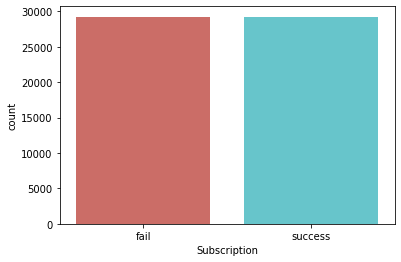

In [9]:
# print(bank_clean['target'].value_counts(normalize=True))
c=sns.countplot(x=os_data_y, palette='hls')#, data=bank_clean, palette='hls', )
plt.xlabel('Subscription')
c.set_xticklabels(['fail','success']);

plt.savefig('img/count_plot_SMOTE')

In [10]:
# after using Synthetic Minority Oversampling Techique
print(os_data_X.shape)
print(os_data_y.shape)
print(os_y.shape)
# os_data_y.value_counts(normalize=True)

(58458, 45)
(58458,)
(58458, 1)


In [11]:
#Perform vanilla logistic regression
logreg_base_SMOTE = LogisticRegression(C = 1e9, class_weight='balanced', solver='newton-cg')
logreg_base_SMOTE.fit(os_data_X, os_data_y)
y_hat_base_SMOTE = logreg_base_SMOTE.predict(os_data_X)

print(f"score = {logreg_base_SMOTE.score(os_data_X, os_data_y)}")
logistic_regression.print_metrics(os_data_y, y_hat_base_SMOTE)


score = 0.708183653221116
precision = 0.75
recall = 0.62
accuracy = 0.75
f1 score = 0.68


The model score decreased again from 0.8 to 0.7.<br>
However, the SMOTE method seems to increase all our metric scores. 

## Step 7.3: Using undersampling technique
This technique undersamples the majority class randomly

In [12]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train_scaled, y_train], axis=1)
X.head()
# separate minority and majority classes
success = X[X.target==1]
failure = X[X.target==0]
print(f"success original count: {len(success)}")
print(f"failure original count: {len(failure)}")

# downsample majority
failure_downsampled = resample(failure,
                               replace = False, # sample without replacement
                               n_samples = len(success), # match minority n
                               random_state = 19) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([failure_downsampled, success])

# checking counts
downsampled.target.value_counts()

success original count: 3711
failure original count: 29229


1    3711
0    3711
Name: target, dtype: int64

In [13]:
# Trying vanilla logistic regression again with the balanced dataset
y_train_undersample = downsampled['target']
X_train_undersample = downsampled.drop('target', axis=1)

downsampled_lr = LogisticRegression(C = 1e9, solver='newton-cg',class_weight='balanced',max_iter=1000)
downsampled_lr.fit(X_train_undersample, y_train_undersample)

downsampled_pred = downsampled_lr.predict(X_train_undersample)

print(f"score = {downsampled_lr.score(X_train_undersample, y_train_undersample)}")
logistic_regression.print_metrics(y_train_undersample, downsampled_pred)

score = 0.7012934518997574
precision = 0.77
recall = 0.58
accuracy = 0.77
f1 score = 0.66


The model score is slightly lower compared to SMOTE. <br>
The metric scores are about the same compared to SMOTE but SMOTE looks slightly better

## logit 

In [15]:
X_col = X_train.columns
X_df = pd.DataFrame(data=os_data_X, columns=X_col)
y_df = pd.DataFrame(data=os_data_y, columns=['Sub'])

# os_data_X_df.head()
print(type(X_df))
print(type(y_df))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [17]:
data_y = os_data_y.reshape(-1,1)
data_y.shape

(58458, 1)

In [18]:
import statsmodels.api as sm
logit_model=sm.Logit(X_df[X_col], data_y).fit()
# result = logit_model.fit()
print(logit_model.summary2())
# result.summary()

# Create, fit model
#     mod = sm.Logit(endog=y_train, exog=X_train)
#     res = mod.fit(method='bfgs', maxiter=100)

ValueError: endog must be in the unit interval.

### Recursive feature elimination

In [68]:
# os_data_y.values.ravel()

array([0, 0, 0, ..., 1, 1, 1])

In [19]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs')

rfe = RFE(logreg, 10)
rfe = rfe.fit(os_data_X, os_data_y)
print(rfe.support_)
print(rfe.ranking_)
# rfe.get_support

[False  True  True False False False False False  True False False False
 False False False False False False False False False False False False
 False  True False False False  True  True False  True False False  True
  True False False False False False False  True False]
[20  1  1  2  7 28 27 19  1 29  9  6  8 33 30 16 15 34 18 36 17 25 26 35
 32  1 12 31 10  1  1 13  1 21  5  1  1  4 14 11 23 22 24  1  3]


In [44]:
os_data_X.columns

Index(['age', 'campaign', 'pdays', 'previous', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'marital_unknown', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'housing_unknown', 'housing_yes',
       'default_unknown', 'default_yes', 'loan_unknown', 'loan_yes',
       'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

In [45]:
col_list = zip(os_data_X.columns, rfe.support_)
X_new_cols = [x[0] for x in col_list if x[1]==True]
X_new_cols

['campaign',
 'pdays',
 'job_retired',
 'default_unknown',
 'contact_telephone',
 'month_aug',
 'month_jul',
 'month_may',
 'month_nov',
 'poutcome_nonexistent']

In [49]:
X_new = os_data_X[X_new_cols]
print(X_new.shape)
X_new.head()


(58458, 10)


,campaign,pdays,job_retired,default_unknown,contact_telephone,month_aug,month_jul,month_may,month_nov,poutcome_nonexistent
0,-0.564625,-0.19645,-0.209108,-0.515042,-0.757855,-0.420234,-0.459331,-0.709185,-0.333783,-2.511053
1,-0.204519,-0.19645,-0.209108,-0.515042,-0.757855,-0.420234,2.177080,-0.709185,-0.333783,0.398239
2,-0.564625,-0.19645,-0.209108,-0.515042,1.319514,-0.420234,2.177080,-0.709185,-0.333783,0.398239
3,0.155587,-0.19645,-0.209108,-0.515042,1.319514,-0.420234,-0.459331,-0.709185,-0.333783,0.398239
4,-0.564625,-0.19645,-0.209108,-0.515042,-0.757855,-0.420234,2.177080,-0.709185,-0.333783,0.398239


In [50]:
#Try applying new feature list into vanilla regression

rfe_lr = LogisticRegression(C = 1e9, solver='newton-cg',class_weight='balanced',max_iter=1000)
rfe_lr.fit(X_new, os_data_y)

rfe_pred = rfe_lr.predict(X_new)

print(f"score = {rfe_lr.score(X_new, os_data_y)}")
logistic_regression.print_metrics(os_data_y, rfe_pred)

score = 0.6940196380307229
precision = 0.74
recall = 0.59
accuracy = 0.74
f1 score = 0.66


#### SM model

In [51]:
import statsmodels.api as sm
logit_model = sm.Logit(os_data_y, X_new)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.581016
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                58458
Model:                          Logit   Df Residuals:                    58448
Method:                           MLE   Df Model:                            9
Date:                Mon, 21 Oct 2019   Pseudo R-squ.:                  0.1618
Time:                        22:00:59   Log-Likelihood:                -33965.
converged:                       True   LL-Null:                       -40520.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
campaign                -0.1951      0.012    -15.938      0.000      -0.219      -0.171

### Cross validation

In [109]:
## To get our baseline, we'll do a 'vanilla' case - no regularization.
## In this case, we do not scale our data
logreg_vanilla = LogisticRegression(C=1e9, solver='newton-cg')
logreg_vanilla.fit(os_data_X, os_data_y)
y_hat_vanilla = logreg_vanilla.predict(X=os_data_X)


In [111]:
print_metrics(os_data_y, y_hat_vanilla)

precision = 0.86
recall = 0.86
accuracy = 0.86
f1 score = 0.86


#### For vanilla

In [ ]:
# import logistic_regression as lr
# vanilla_result = lr.cross_validation(n=10, shuffle=True, lr='vanilla', X_train=os_data_X, y_train=os_data_y)
# vanilla_result

#### For l2

In [ ]:
# l2_result = lr.cross_validation(n=10, shuffle=True, lr='l2', X_train=os_data_X, y_train=os_data_y)
# l2_result

In [ ]:
l2_reg = LogisticRegression(C=1, solver='newton-cg', class_weight='balanced', max_iter=1000)
l2_reg.fit(os_data_X, os_data_y)
l2_reg_prd = l2_reg.predict(os_data_X)
print_metrics(os_data_y, l2_reg_prd,lr_reg=l2_reg)

#### For l1

In [ ]:
l1_reg = LogisticRegression(C=1, solver='saga',penalty='l1', max_iter=1000)
l1_reg.fit(os_data_X, os_data_y)
l1_reg_prd = l1_reg.predict(os_data_X)
print_metrics(os_data_y, l1_reg_prd, lr_reg=l1_reg)

In [ ]:
l1_result = lr.cross_validation(n=10, shuffle=True, lr='l1', X_train=os_data_X, y_train=os_data_y)
l1_result

In [ ]:
# calculate the mean
print('vanilla regularization', vanilla_result.mean(axis=0))
print('l1 regularization', l1_result.mean(axis=0))
print('l2 regularixation', l2_result.mean(axis=0))

In [ ]:
# calculate the std
print('vanilla regularization', vanilla_result.std(axis=0))
print('l1 regularization', l1_result.std(axis=0))
print('l2 regularixation', l2_result.std(axis=0))

In [ ]:
y_hat_df = pd.DataFrame(data=y_hat, columns=['y_hat'])
y_hat_df.y_hat.value_counts(normalize=True)

In [ ]:
true_posetive = np.count_nonzero(y_hat)
accuracy = true_posetive/len(y_hat)
print('accuracy', accuracy)
print('values', len(y_hat))


## Step 4: Modify data for Machine Learning

In [ ]:
X_train.head()

In [ ]:
bank_clean.columns

In [ ]:
dummed_train = pd.get_dummies(X_train, 
               columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'season', 'day_of_week', 'poutcome'], 
               drop_first= True)

In [ ]:
dummed_train.head()
print(dummed_train.shape)
print(dummed_train.columns)

In [ ]:
# calculate for age
mu, std = dummed_train.age.mean(), dummed_train.age.std()
print('mean age', mu, 'age std', std)
print('Standardized value for the first row is:', (dummed_train.age[1233]-mu)/std)
print(dummed_train.age[1233])
dummed_train.head()

## Step 7: Logistic Regression

In [ ]:
## To get our baseline, we'll do a 'vanilla' case - no regularization.
## In this case, we do not scale our data
logreg = LogisticRegression(class_weight='balanced', solver='newton-cg')
logreg.fit(dummed_train, y_train)

In [ ]:
print(logreg.score(dummed_train, y_train))

In [ ]:

#Standard Scaler to be used within pipelines.  
class StScaler(StandardScaler):
    def fit_transform(slf,X,y=None):
        print(f"transformed rows: {len(X)}")
        return super().fit_transform(X,y)

#Using pipeline to avoid data leakage within CV process 
pipe = Pipeline([
    ('scaler', StScaler()),
    ('logreg', LogisticRegression(C = 1e9, 
                                 solver = 'newton-cg',
                                 max_iter = 1000,
                                 class_weight = 'balanced'))
])

print(f"train data length: {len(dummed_train)} rows")
print(cross_val_score(pipe,dummed_train,y_train, cv=5))

## Step 8: Parameter Tuning

In [ ]:
#GridSearchCV for parameter tuning

# param_grid = {''}

# search = GridSearchCV(estimator=pipe,
#                       cv=5,
#                       param_grid=
#                       return_train_score=True)

# search.fit(X_train, y_train)
